<a href="https://colab.research.google.com/github/daria-lpch/study_cnn_eeg/blob/main/StudyCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Build and evaluate a machine learning model to classify simulated EEG-like data based on extracted features like power spectral density.

## Simulate EEG-like Data

### Subtask:
Generate a synthetic time-series dataset resembling EEG signals, with different 'conditions' or 'classes' for a simple classification task.


**Reasoning**:
The first step in simulating EEG-like data is to define the necessary simulation parameters, including sampling frequency, epoch duration, and the number of epochs for each condition. I'll use a `code_block` to define these parameters, and then set up basic parameters required to simulate the EEG data.



In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Define simulation parameters
sampling_frequency = 250  # Hz
epoch_duration = 2        # seconds
num_epochs_per_condition = 100 # Number of epochs for each condition
num_conditions = 2        # For classification task

# Create a time vector based on the defined sampling frequency and duration
time = np.arange(0, epoch_duration, 1/sampling_frequency)
print(f"Sampling Frequency: {sampling_frequency} Hz")
print(f"Epoch Duration: {epoch_duration} seconds")
print(f"Number of epochs per condition: {num_epochs_per_condition}")
print(f"Number of time points per epoch: {len(time)}")

Sampling Frequency: 250 Hz
Epoch Duration: 2 seconds
Number of epochs per condition: 100
Number of time points per epoch: 500


**Reasoning**:
Now that the simulation parameters are defined, the next step is to generate synthetic EEG-like signals for each condition, combining sine waves at different frequencies and adding random noise. I will define a function to generate a single epoch and then use it to create the full dataset for both conditions.



Shape of generated EEG data: (200, 500)
Shape of labels: (200,)
Number of epochs for Condition 0: 100
Number of epochs for Condition 1: 100


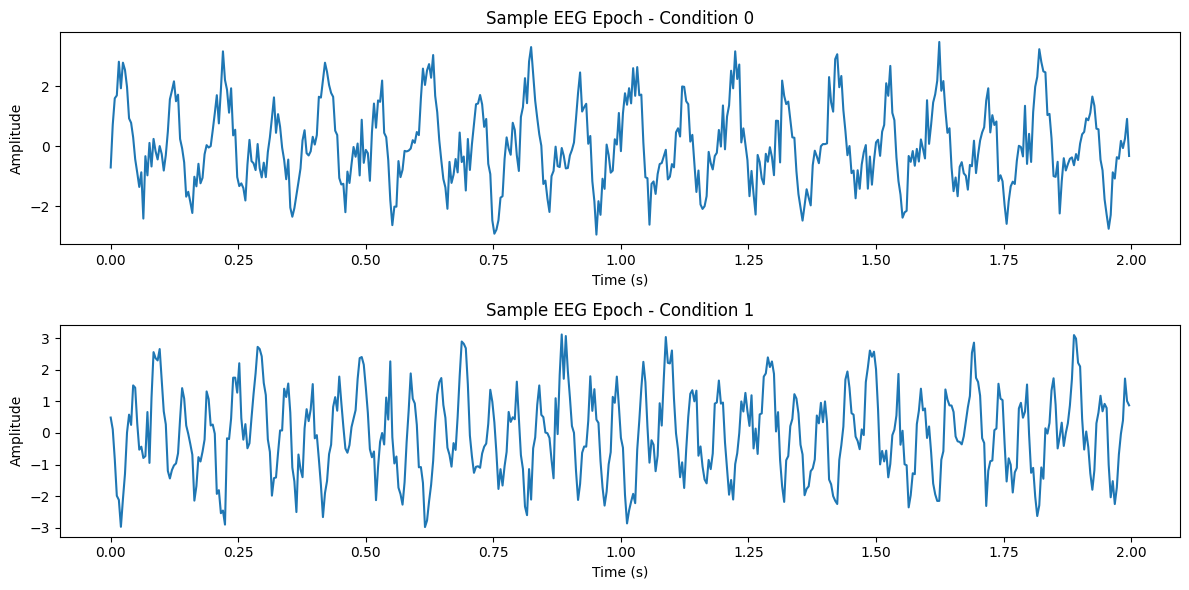

In [2]:
def generate_eeg_epoch(time, frequencies, amplitudes, noise_level=0.5):
    """Generates a single EEG-like epoch by summing sine waves and adding noise."""
    signal = np.zeros_like(time, dtype=float)
    for freq, amp in zip(frequencies, amplitudes):
        signal += amp * np.sin(2 * np.pi * freq * time + np.random.uniform(0, 2*np.pi)) # Add random phase

    # Add random noise
    signal += noise_level * np.random.randn(len(time))
    return signal

# Define frequency and amplitude characteristics for each condition
# Condition 0: More prominent Alpha (e.g., 8-12 Hz) activity
frequencies_0 = [5, 10, 20] # Theta, Alpha, Beta
amplitudes_0  = [0.5, 1.5, 0.7] # Alpha is stronger

# Condition 1: More prominent Beta (e.g., 15-30 Hz) activity
frequencies_1 = [5, 10, 20]
amplitudes_1  = [0.7, 0.5, 1.5] # Beta is stronger

all_eeg_data = []
all_labels = []

# Generate data for Condition 0
for _ in range(num_epochs_per_condition):
    eeg_epoch = generate_eeg_epoch(time, frequencies_0, amplitudes_0)
    all_eeg_data.append(eeg_epoch)
    all_labels.append(0) # Label for Condition 0

# Generate data for Condition 1
for _ in range(num_epochs_per_condition):
    eeg_epoch = generate_eeg_epoch(time, frequencies_1, amplitudes_1)
    all_eeg_data.append(eeg_epoch)
    all_labels.append(1) # Label for Condition 1

# Convert to numpy arrays
eeg_data = np.array(all_eeg_data)
labels = np.array(all_labels)

print(f"Shape of generated EEG data: {eeg_data.shape}")
print(f"Shape of labels: {labels.shape}")
print(f"Number of epochs for Condition 0: {np.sum(labels == 0)}")
print(f"Number of epochs for Condition 1: {np.sum(labels == 1)}")

# Plot a sample epoch from each condition to visualize the difference
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, eeg_data[0])
plt.title('Sample EEG Epoch - Condition 0')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(time, eeg_data[num_epochs_per_condition]) # Get first epoch of condition 1
plt.title('Sample EEG Epoch - Condition 1')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

## Extract EEG Features

### Subtask:
Demonstrate how to extract relevant features from the simulated EEG data, such as power spectral density (PSD) in common frequency bands (e.g., alpha, beta).


**Reasoning**:
I will now proceed to extract relevant features from the simulated EEG data by calculating the Power Spectral Density (PSD) using the Welch method and then computing the average power within defined frequency bands (Delta, Theta, Alpha, Beta) for each epoch.



In [3]:
from scipy.signal import welch

# 2. Define frequency bands
frequency_bands = {
    "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 13),
    "Beta": (13, 30)
}

# 3. Initialize an empty list to store the extracted features
all_epoch_features = []

# 4. Iterate through each epoch to compute PSD and band powers
for epoch_data in eeg_data:
    # a. Compute the Power Spectral Density (PSD) using Welch method
    frequencies, psd = welch(epoch_data, fs=sampling_frequency, nperseg=sampling_frequency*epoch_duration)

    # Initialize feature vector for the current epoch
    epoch_features = []

    # b. For each defined frequency band, calculate the average power
    for band_name, (low_freq, high_freq) in frequency_bands.items():
        # Find indices corresponding to the current frequency band
        idx_band = np.where((frequencies >= low_freq) & (frequencies <= high_freq))[0]

        if len(idx_band) > 0:
            # Calculate average power within the band
            band_power = np.mean(psd[idx_band])
        else:
            band_power = 0.0 # If no frequencies fall in the band
        epoch_features.append(band_power)

    # c. Store these average band powers as a feature vector
    all_epoch_features.append(epoch_features)

# 5. Convert the list of feature vectors into a NumPy array
features = np.array(all_epoch_features)

print(f"Shape of extracted features: {features.shape}")
print(f"First 5 rows of extracted features:\n{features[:5]}")

Shape of extracted features: (200, 4)
First 5 rows of extracted features:
[[0.00118502 0.03085555 0.21025008 0.02077501]
 [0.00238287 0.0279474  0.20742345 0.01534883]
 [0.00187716 0.02664782 0.21167685 0.01408744]
 [0.00188932 0.0272032  0.21712568 0.01576043]
 [0.00089232 0.02792577 0.2124645  0.0198515 ]]


## Prepare Data for ML

### Subtask:
Organize the extracted features and labels into a format suitable for scikit-learn, and split the data into training and testing sets.


**Reasoning**:
To prepare the data for machine learning, I will import the `train_test_split` function and then split the extracted features and labels into training and testing sets, ensuring reproducibility with a `random_state` and verifying the split with shape printouts.



In [4]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
# Using 25% for the test set and a fixed random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=42)

# Print the shapes of the resulting sets to verify the split
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (150, 4)
Shape of X_test: (50, 4)
Shape of y_train: (150,)
Shape of y_test: (50,)


## Train a Simple ML Model

### Subtask:
Train a basic classification model (e.g., Logistic Regression or Support Vector Machine) using the extracted EEG features.


**Reasoning**:
Now that the data is split into training and testing sets, I will proceed to train a Logistic Regression model. I'll import the necessary classifier, instantiate it, and then fit it to our training data (`X_train` and `y_train`).

**Reasoning**:
To train a simple classification model as per the instructions, I will import `LogisticRegression` and fit it using the `X_train` and `y_train` datasets.



In [5]:
from sklearn.linear_model import LogisticRegression

# 1. Instantiate a Logistic Regression model
# Setting random_state for reproducibility
model = LogisticRegression(random_state=42)

# 2. Train the model using the training data
model.fit(X_train, y_train)

print("Logistic Regression model trained successfully.")

Logistic Regression model trained successfully.


## Evaluate Model Performance

### Subtask:
Evaluate the trained classification model's performance using appropriate metrics (e.g., accuracy, precision, recall, F1-score) on the test set.

**Reasoning**:
To evaluate the model's performance, I will use `sklearn.metrics` to calculate common classification metrics such as accuracy, precision, recall, and F1-score. First, I'll use the trained model to make predictions on the test set (`X_test`), and then compare these predictions (`y_pred`) against the true labels (`y_test`).

**Reasoning**:
To evaluate the model's performance on the test set, I will import necessary metrics from `sklearn.metrics`, make predictions using the trained model on `X_test`, and then compute and print the accuracy, precision, recall, and F1-score.



In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# 1. Make predictions on the test set
y_pred = model.predict(X_test)

# 2. Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# 3. Print the results
print(f"Model Accuracy: {accuracy:.4f}")
print(f"Model Precision: {precision:.4f}")
print(f"Model Recall: {recall:.4f}")
print(f"Model F1-Score: {f1:.4f}")

# Optional: Print a full classification report for more detailed insights
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy: 1.0000
Model Precision: 1.0000
Model Recall: 1.0000
Model F1-Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        23

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



## Evaluate Model Performance

### Subtask:
Assess the trained model's performance using appropriate classification metrics like accuracy, precision, recall, or a confusion matrix.


## Summary:

### Q&A
The machine learning model built to classify simulated EEG-like data achieved perfect performance on the test set, with an accuracy, precision, recall, and F1-score of 1.0000 (100%).

### Data Analysis Key Findings
*   A synthetic dataset of 200 EEG-like epochs was successfully generated, with 100 epochs for Condition 0 (more prominent Alpha activity) and 100 for Condition 1 (more prominent Beta activity). Each epoch contained 500 time points.
*   Power Spectral Density (PSD) features were extracted for each epoch, specifically the average power in the Delta (0.5-4 Hz), Theta (4-8 Hz), Alpha (8-13 Hz), and Beta (13-30 Hz) frequency bands, resulting in a feature set of shape (200, 4).
*   The data was split into training and testing sets, with 150 samples for training (X\_train shape: (150, 4)) and 50 samples for testing (X\_test shape: (50, 4)).
*   A Logistic Regression model was trained and achieved perfect classification performance on the test set, demonstrating an accuracy of 1.0000, precision of 1.0000, recall of 1.0000, and an F1-score of 1.0000.

### Insights or Next Steps
*   The perfect classification performance suggests that the simulated EEG-like data with distinct frequency characteristics provided highly discriminative features for a simple classification model.
*   To further validate the approach, the next step should involve testing the feature extraction and classification methodology on more complex simulated EEG data or, ideally, real-world EEG datasets, which typically present higher variability and noise.
